# Convolutional Neural Networks

## Project: Algorithm for a Dog Identification App 



---
### Why We're Here 

The code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed (133 diffrent breeds).  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project. 

![Sample Dog Output](images/sample_dog_output.png)

The algorithm could be used as part of a mobile or web app.

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): The Algorithm
* [Step 6](#step6): Test The Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

Make sure that you've downloaded the required human and dog datasets:
* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dogImages`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [3]:
import numpy as np
from glob import glob

# load filenames for human and dog images
human_files = np.array(glob("lfw/*/*"))
dog_files = np.array(glob("dogImages/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  


Number of faces detected: 1


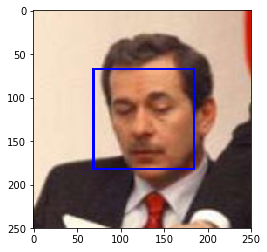

In [4]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[50])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [5]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### Human Face Detector

Test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

In [6]:
from tqdm import tqdm

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

#-#-# Do NOT modify the code above this line. #-#-#

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
humanFace = 0
for i in human_files_short:
    if face_detector(i):
        humanFace += 1
percentageHumanFace = 100. * float(humanFace) / len(human_files_short)
print("Detected humas faces in HumanData: " + str(percentageHumanFace)+ "%")

dogFace = 0
for i in dog_files_short:
    if face_detector(i):
        dogFace += 1
percentageDogFace = 100. * float(dogFace) / len(dog_files_short)
print("Detected humas faces in DogData: " + str(percentageDogFace)+ "%")

Detected humas faces in HumanData: 96.0%
Detected humas faces in DogData: 18.0%


---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/). ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [7]:
import torch
import torchvision.models as models

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

In [8]:
print(VGG16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### Making Predictions with a Pre-trained Model

A function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  


In [9]:
from PIL import Image
import torchvision.transforms as transforms

# Set PIL to be tolerant of image files that are truncated.
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def VGG16_predict(img_path):
    '''
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    
    image = Image.open(img_path) 
    transform = transforms.Compose([
                        transforms.RandomResizedCrop(224),
                        transforms.ToTensor(),
                        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                             std=[0.229, 0.224, 0.225])])

    image = transform(image)[:3,:,:].unsqueeze(0)

    if use_cuda:
        image = image.cuda()
    VGG16.eval()
    output = VGG16(image) 

    _, pred = torch.max(output, 1)   

    return int(pred) # predicted class index

In [10]:
#Test
VGG16_predict('dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg')
#dic: 252: 'affenpinscher, monkey pinscher, monkey dog',

252

###  Dog Detector

[dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a) The categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive.

In [11]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    Detector = VGG16_predict(img_path)
    if int(Detector) in range(151, 269):    
        return True # true/false
    else:
        return False

In [12]:
#Test
dog_detector('dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg')

True

In [43]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
humanFace = 0
for i in human_files_short:
    if dog_detector(i):
        humanFace += 1
print("Detected dogs in HumanData: " + str(humanFace)+ "%")

dogFace = 0
for i in dog_files_short:
    if dog_detector(i):
        dogFace += 1
print("Detected dogs in DogData: " + str(dogFace)+ "%")

Detected dogs in HumanData: 0%
Detected dogs in DogData: 89%


---
<a id='step3'></a>
## Step 3: CNN to Classify Dog Breeds (from Scratch)

The task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">


Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


### Data Loaders for the Dog Dataset


In [3]:
#new
import os
import numpy as np
import torch

import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt

batch_size = 30
num_workers= 0


data_dir = 'dogImages/'
train_dir = os.path.join(data_dir, 'train/')
valid_dir = os.path.join(data_dir, 'valid/')
test_dir = os.path.join(data_dir, 'test/')


data_transform = {'train': transforms.Compose([transforms.RandomRotation(10),
                                    transforms.RandomVerticalFlip(p=0.1),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                                         std=[0.5, 0.5, 0.5])]),
                  'valid': transforms.Compose([transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                                         std=[0.5, 0.5, 0.5])]),
                  'test': transforms.Compose([transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                                         std=[0.5, 0.5, 0.5])])}


image_dataset = {'train': datasets.ImageFolder(train_dir, transform=data_transform['train']),
                 'valid': datasets.ImageFolder(valid_dir, transform=data_transform['valid']),
                 'test': datasets.ImageFolder(test_dir, transform=data_transform['test'])}


loaders_scratch = {'train': torch.utils.data.DataLoader(image_dataset['train'], batch_size=20, 
                                               num_workers=num_workers, shuffle=True),
                   'valid': torch.utils.data.DataLoader(image_dataset['valid'], batch_size=10, 
                                               num_workers=num_workers, shuffle=True),
                   'test': torch.utils.data.DataLoader(image_dataset['test'], batch_size=20, 
                                               num_workers=num_workers, shuffle=True)}


In [17]:
print('training: ', len(image_dataset['train']))
print('valid: ', len(image_dataset['valid']))
print('test: ', len(image_dataset['test']))

training:  6680
valid:  835
test:  836


### Model Architecture


In [8]:
import torch.nn as nn
import torch.nn.functional as F

use_cuda = torch.cuda.is_available()

# CNN architecture
class Net(nn.Module):
    def __init__(self):
        #super(Net, self).__init__()
        #self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        #self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        #self.conv3 = nn.Conv2d(64, 64, 3, padding=1)
        #self.conv4 = nn.Conv2d(64, 128, 3, padding=1)
        #self.conv5 = nn.Conv2d(128, 128, 3, padding=1)
        #self.conv6 = nn.Conv2d(128, 256, 3, padding=1)
        #self.conv7 = nn.Conv2d(256, 256, 3, padding=1)
        #self.conv8 = nn.Conv2d(256, 512, 3, padding=1)
         
        #self.pool = nn.MaxPool2d(2, 2)
        
        #self.fc1 = nn.Linear(512 * 7 * 7, 1000)
        #self.fc2 = nn.Linear(1000, 500)
        #self.fc3 = nn.Linear(500, 133)
        
        #self.dropout = nn.Dropout(0.5)
               
        
        #def forward(self, x):
        #x = self.pool(F.relu(self.conv1(x)))
        #x = F.relu((self.conv2(x))
        #x = self.pool(F.relu(self.conv3(x)))
        #x = F.relu(self.conv4(x))
        #x = self.pool(F.relu(self.conv5(x)))
        # = F.relu(self.conv6(x))
        #x = self.pool(F.relu(self.conv7(x)))
        #x = self.pool(F.relu(self.conv8(x)))

        
        #x = x.view(-1, 512 * 7 * 7)
        #x = F.relu(self.fc1(x))
        #x = self.dropout(x)
        #x = F.relu(self.fc2(x))
        #x = self.dropout(x)
        #x = self.fc3(x)
        
        #---------------------------------> 8% accuracy (model_scratch_one)
                
        
        super(Net, self).__init__()
        self.conv1= nn.Conv2d(3, 16, 3, padding=1)
        self.conv1_bn = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv2_bn = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3_bn = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv4_bn = nn.BatchNorm2d(128)
        self.conv5 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv5_bn = nn.BatchNorm2d(256)
         
        self.pool = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(256 * 7 * 7, 500)
        self.fc2 = nn.Linear(500, 500)
        self.fc3 = nn.Linear(500, 133)
        
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1_bn(self.conv1(x))))
        x = self.pool(F.relu(self.conv2_bn(self.conv2(x))))
        x = self.pool(F.relu(self.conv3_bn(self.conv3(x))))
        x = self.pool(F.relu(self.conv4_bn(self.conv4(x))))
        x = self.pool(F.relu(self.conv5_bn(self.conv5(x))))
        
        
        #Instead of relu() -> ELU()
        x = x.view(-1, 256 * 7 * 7)
        x = F.relu(self.fc1(x))
        #x = nn.ELU(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        #x = nn.ELU(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        
        
        
        return x

model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

New initial weights.


In [9]:
def weights_init_uniform_rule(m):
    classname = m.__class__.__name__

    if classname.find('Linear') != -1:
        # get the number of the inputs
        n = m.in_features
        y = 1.0/np.sqrt(n)
        m.weight.data.uniform_(-y, y)
        m.bias.data.fill_(0)

model_scratch.apply(weights_init_uniform_rule)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=12544, out_features=500

### Loss Function and Optimizer


In [20]:
import torch.optim as optim

criterion_scratch = nn.CrossEntropyLoss()

#optimizer_scratch = torch.optim.Adam(model_scratch.parameters(), lr=0.01)
optimizer_scratch = optim.SGD(model_scratch.parameters(), lr=0.01, momentum=0.9)

### Train and Validate the Model

Save the final model parameters at filepath `'model_scratch.pt'`.

In [29]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
        
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            
            
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):

            if use_cuda:
                data, target = data.cuda(), target.cuda()

            output = model(data)
            loss = criterion(output, target)
            
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        # save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            torch.save(model.state_dict(), 'model_scratch.pt')
            valid_loss_min = valid_loss
            
    return model


# train the model
model_scratch = train(100, loaders_scratch, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

Epoch: 1 	Training Loss: 4.829242 	Validation Loss: 4.623650
Epoch: 2 	Training Loss: 4.703374 	Validation Loss: 4.666183
Epoch: 3 	Training Loss: 4.650666 	Validation Loss: 4.606972
Epoch: 4 	Training Loss: 4.640667 	Validation Loss: 4.579323
Epoch: 5 	Training Loss: 4.604055 	Validation Loss: 4.546538
Epoch: 6 	Training Loss: 4.549521 	Validation Loss: 4.457163
Epoch: 7 	Training Loss: 4.502148 	Validation Loss: 4.429877
Epoch: 8 	Training Loss: 4.472150 	Validation Loss: 4.375039
Epoch: 9 	Training Loss: 4.422514 	Validation Loss: 4.291526
Epoch: 10 	Training Loss: 4.370051 	Validation Loss: 4.304930


KeyboardInterrupt: 

If u interrupt the training, u can use the last saved model.

In [24]:
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

### Test the Model


In [22]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
    #for batch_idx, (data, target) in enumerate(test_loader):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function    


In [25]:
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 3.313485


Test Accuracy: 22% (191/836)


---
<a id='step4'></a>
## Step 4: CNN to Classify Dog Breeds (using Transfer Learning)


### Data Loaders for the Dog Dataset

In [50]:
import os
import numpy as np
import torch

import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt

batch_size = 30
num_workers= 0


data_dir = 'dogImages/'
train_dir = os.path.join(data_dir, 'train/')
valid_dir = os.path.join(data_dir, 'valid/')
test_dir = os.path.join(data_dir, 'test/')

data_transform = {'train': transforms.Compose([transforms.RandomRotation(10),
                                    transforms.RandomVerticalFlip(p=0.1),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                                         std=[0.5, 0.5, 0.5])]),
                  'valid': transforms.Compose([transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                                         std=[0.5, 0.5, 0.5])]),
                  'test': transforms.Compose([transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                                         std=[0.5, 0.5, 0.5])])}

image_dataset = {'train': datasets.ImageFolder(train_dir, transform=data_transform['train']),
                 'valid': datasets.ImageFolder(valid_dir, transform=data_transform['valid']),
                 'test': datasets.ImageFolder(test_dir, transform=data_transform['test'])}

loaders_transfer = {'train': torch.utils.data.DataLoader(image_dataset['train'], batch_size=20, 
                                               num_workers=num_workers, shuffle=True),
                    'valid': torch.utils.data.DataLoader(image_dataset['valid'], batch_size=10, 
                                               num_workers=num_workers, shuffle=True),
                    'test': torch.utils.data.DataLoader(image_dataset['test'], batch_size=20, 
                                               num_workers=num_workers, shuffle=True)}

### Model Architecture


In [51]:
import torchvision.models as models
import torch.nn as nn

use_cuda = torch.cuda.is_available()

model_transfer = models.vgg16(pretrained=True)

for param in model_transfer.features.parameters():
    param.requires_grad = False

model_transfer.classifier[6].out_features = 133

def weights_init_uniform_rule(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        n = m.in_features
        y = 1.0/np.sqrt(n)
        m.weight.data.uniform_(-y, y)
        m.bias.data.fill_(0)

model_transfer.apply(weights_init_uniform_rule)

if use_cuda:
    model_transfer = model_transfer.cuda()

print(model_transfer)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

### Loss Function and Optimizer


In [52]:
import torch.optim as optim

criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.SGD(model_transfer.classifier.parameters(), lr=0.01)

### Train and Validate the Model

Save the final model parameters at filepath `'model_transfer.pt'`.

In [4]:
n_epochs = 30

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True


def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""

    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
       
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):

            if use_cuda:
                data, target = data.cuda(), target.cuda()
            
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):

            if use_cuda:
                data, target = data.cuda(), target.cuda()

            output = model(data)
            loss = criterion(output, target)
            
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            torch.save(model.state_dict(), 'model_transfer.pt')
            valid_loss_min = valid_loss
            
    return model

model_transfer = train(n_epochs, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')

model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch: 1 	Training Loss: 4.543347 	Validation Loss: 2.679763
Epoch: 2 	Training Loss: 2.441053 	Validation Loss: 1.882854
Epoch: 3 	Training Loss: 1.812779 	Validation Loss: 1.565593
Epoch: 4 	Training Loss: 1.477254 	Validation Loss: 1.427714
Epoch: 5 	Training Loss: 1.228798 	Validation Loss: 1.340386
Epoch: 6 	Training Loss: 1.060179 	Validation Loss: 1.331190
Epoch: 7 	Training Loss: 0.902983 	Validation Loss: 1.318385
Epoch: 8 	Training Loss: 0.781365 	Validation Loss: 1.246422
Epoch: 9 	Training Loss: 0.679199 	Validation Loss: 1.316108
Epoch: 10 	Training Loss: 0.596167 	Validation Loss: 1.301916
Epoch: 11 	Training Loss: 0.538358 	Validation Loss: 1.310429
Epoch: 12 	Training Loss: 0.482601 	Validation Loss: 1.361773
Epoch: 13 	Training Loss: 0.440581 	Validation Loss: 1.274068
Epoch: 14 	Training Loss: 0.384004 	Validation Loss: 1.274292
Epoch: 15 	Training Loss: 0.357426 	Validation Loss: 1.339619
Epoch: 16 	Training Loss: 0.349104 	Validation Loss: 1.341716
Epoch: 17 	Traini

KeyboardInterrupt: 

If u interrupt the training, u can use the last saved model.

In [53]:
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

### Test the Model


In [30]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 1.357756


Test Accuracy: 63% (528/836)


After only 17 epochs, the test accuracy is 63%. 

### Predict Dog Breed with the Model
 

In [46]:
from PIL import Image

# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in image_dataset['train'].classes]

def predict_breed_transfer(img_path):
    # load the image and return the predicted breed
    image = Image.open(img_path) 
    transform = transforms.Compose([
                        transforms.Resize(224),
                        transforms.ToTensor(),
                        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                             std=[0.229, 0.224, 0.225])])

    image = transform(image)[:3,:,:].unsqueeze(0)

    if use_cuda:
        image = image.cuda()
    model_transfer.eval()
    output = model_transfer(image) 
    _, pred = torch.max(output, 1)   
    return class_names[pred]

---
<a id='step5'></a>
## Step 5: The Algorithm

The algorithm accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.


In [87]:
def run_app(img_path):
    if dog_detector(img_path):  
        from IPython.core.display import Image, display
        display(Image(img_path,width=200,height=200))
        print('Dog detected')
        print(predict_breed_transfer(img_path))
    elif face_detector(img_path):
        from IPython.core.display import Image, display
        display(Image(img_path,width=200,height=200))
        print('face detected')
        print(predict_breed_transfer(img_path))
    else:
        print('Picture includes no dog and no face')


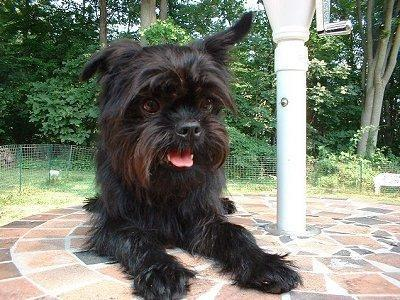

Dog detected
Affenpinscher


In [88]:
#Test
run_app('dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg')

---
<a id='step6'></a>
## Step 6: Test The Algorithm


In [39]:
import numpy as np
from glob import glob


testfiles = np.array(glob("Test/*"))

for file in np.hstack(testfiles):
    print(file)
    run_app(file)

Test\cat1.jpg
Picture includes no dog and no face
Test\cat2.jpg
Picture includes no dog and no face
Test\dog1.jpg
Dog detected
Labrador retriever
Test\dog2.jpg
Dog detected
Bulldog
Test\me.jpg
face detected
Bull terrier
Test\me2.jpg
Picture includes no dog and no face


The prediction of 6 test-files:
- both cat pictures had no dog/no face
- both dog pictures were recognized correctly
- The first picture of me was recognized as a bull terrier. The second picture of me includes no dog and no face.

To improve the algorithm:
- the CNN -> more filters and more linear layers
- epochs -> increase the number of epochs
- learning rate -> decrease the learning rate (so I need more epochs)
- batch size